# American Put Option Valuation using Binomial Tree

In [5]:
# American Put Option Valuation using Binomial Tree
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import warnings
from datetime import datetime
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
# Pulling close price as at 16 May 2025 from yfinance
ticker = "CBA.AX"
valuation_date = datetime(2025, 5, 16)
expiry_date = datetime(2026, 5, 15)
target_date_str = valuation_date.strftime("%Y-%m-%d")
data = yf.download(ticker, start=target_date_str, end="2026-05-17", progress=False)
if data.empty:
    raise ValueError(f"No data available for {ticker} on {target_date_str}")
S0 = float(data["Close"].iloc[0])  # Ensure scalar

# Calculate time to maturity dynamically 
T = (expiry_date - valuation_date).days / 365.25  # Year fraction


# Pull volatility (sigma) from cell R12 in sheet "Worksheet"
vol_file = "CBA Volatility.xlsx"
from openpyxl import load_workbook

# Open the workbook and access the value from R12
wb = load_workbook(filename=vol_file, data_only=True)
ws = wb["Worksheet"]
sigma = ws["Q11"].value  # This returns the evaluated result (not the formula)

if sigma is None:
    raise ValueError("Volatility (sigma) in cell R12 returned None — please check if Excel formula has been calculated and saved.")

wb.close()

YF.download() has changed argument auto_adjust default to True


/tmp/ipykernel_60982/510970469.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(data["Close"].iloc[0])  # Ensure scalar


In [7]:
# Option parameters
K = 170.00
T = 1.0
r = 0.04
N = 3
print(f"Inputs:\nSpot = {S0:.2f}, Strike = {K}, Time = {T}, Rate = {r}, Volatility = {sigma:.2%}")

Inputs:
Spot = 169.66, Strike = 170.0, Time = 1.0, Rate = 0.04, Volatility = 22.93%


In [9]:
# Binomial pricing for American Put Option
def binomial_american_put(S0, K, T, r, sigma, N):
    """
    Prices an American put option using the binomial tree method.
    Returns: (option_price, stock_tree, option_tree)
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize trees
    stock_tree = np.zeros((N + 1, N + 1))
    option_tree = np.zeros((N + 1, N + 1))

    # Build stock price tree
    for i in range(N + 1):
        for j in range(i + 1):
            stock_tree[i, j] = S0 * (u ** j) * (d ** (i - j))

    # Option value at maturity
    for j in range(N + 1):
        option_tree[N, j] = max(K - stock_tree[N, j], 0)

    # Backward induction for American option
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            hold = np.exp(-r * dt) * (p * option_tree[i + 1, j + 1] + (1 - p) * option_tree[i + 1, j])
            exercise = K - stock_tree[i, j]
            option_tree[i, j] = max(hold, exercise)
    return option_tree[0, 0], stock_tree, option_tree

In [10]:
# Calculate the American put option price and trees
option_price, stock_tree, option_tree = binomial_american_put(S0, K, T, r, sigma, N)
# Visualise the tree
def plot_binomial_tree(stock_tree, option_tree, N):
    """
    Visualizes the binomial trees for stock prices and option values.
    """
    G = nx.DiGraph()
    pos = {}
    # Add nodes with stock and option values
    for i in range(N + 1):
        for j in range(i + 1):
            node_id = f"{i},{j}"
            stock_price = stock_tree[i, j]
            option_value = option_tree[i, j]
            G.add_node(node_id, stock_price=stock_price, option_value=option_value)
            pos[node_id] = (i, j - i / 2)
    # Add edges for tree structure
    for i in range(N):
        for j in range(i + 1):
            G.add_edge(f"{i},{j}", f"{i+1},{j+1}")
            G.add_edge(f"{i},{j}", f"{i+1},{j}")
    # Plot stock price tree
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f"American Put Option - Binomial Tree (N={N})")
    nx.draw_networkx_nodes(G, pos, ax=ax1, node_size=700, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, ax=ax1, alpha=0.3)
    labels1 = {n: f"${G.nodes[n]['stock_price']:.2f}" for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels1, ax=ax1, font_size=8)
    ax1.set_title("Stock Price Tree")
    # Flip y-axis for option value tree
    pos_option = {n: (x, -y) for n, (x, y) in pos.items()}
    nx.draw_networkx_nodes(G, pos_option, ax=ax2, node_size=700, node_color='lightcoral')
    nx.draw_networkx_edges(G, pos_option, ax=ax2, alpha=0.3)
    labels2 = {n: f"${G.nodes[n]['option_value']:.2f}" for n in G.nodes()}
    nx.draw_networkx_labels(G, pos_option, labels=labels2, ax=ax2, font_size=8)
    ax2.set_title("Option Value Tree")
    ax1.axis('off')
    ax2.axis('off')
    plt.tight_layout()
    plt.show()


American Put Option Value: $13.97


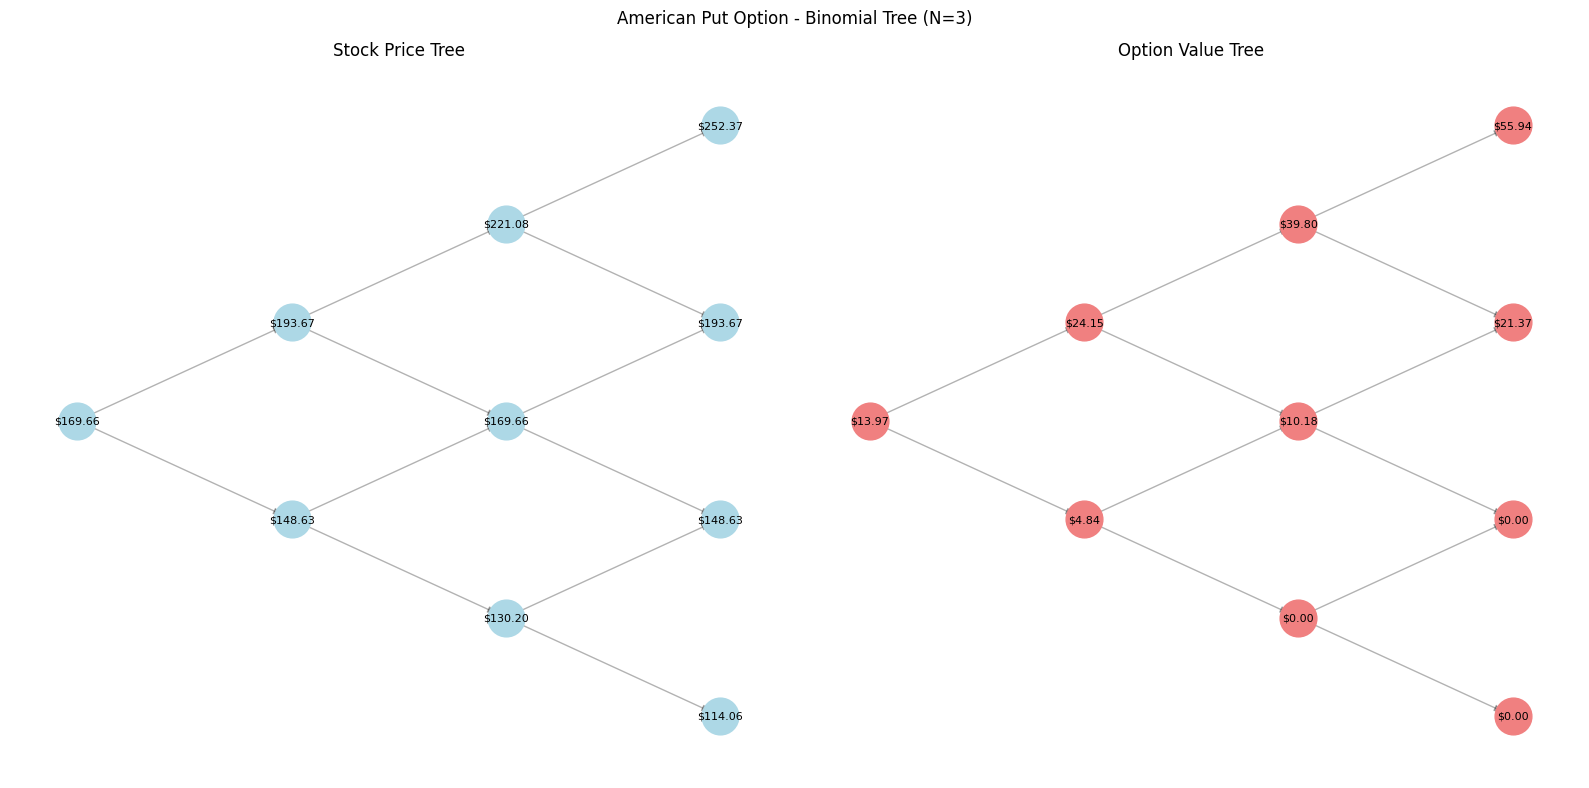

In [11]:
# Print the option price
print(f"\nAmerican Put Option Value: ${option_price:.2f}")
#Visualise the binomial trees
plot_binomial_tree(stock_tree, option_tree, N)